In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
df = pd.read_csv("Breast_cancer_data.csv")

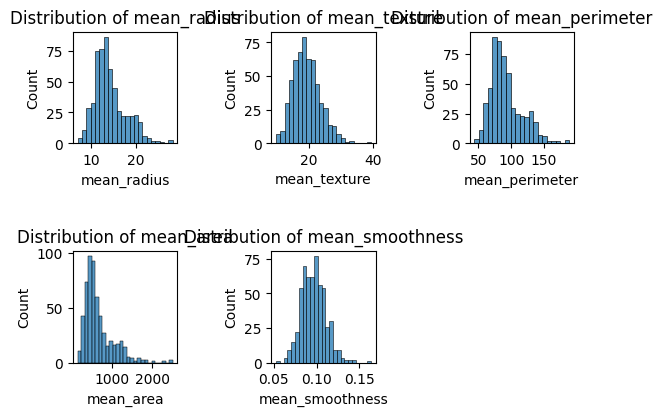

In [36]:
# plt.figure(figsize=(10,8))
key_features = ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area','mean_smoothness']
for i, feature in enumerate(key_features):
    plt.subplot(2,3,i+1)
    sns.histplot(df[feature], kde=False)
    plt.title(f'Distribution of {feature}')

plt.tight_layout(pad=3.0)
plt.show()

In [37]:
print(df.isnull().values)

[[False False False False False False]
 [False False False False False False]
 [False False False False False False]
 ...
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]]


In [38]:
names=[]
for c in df.columns:
    if c!='diagnosis':
        names.append(c)
X = df[names].values
y = df['diagnosis'].values.reshape(-1, 1)

# def scale(X):
#     mean = np.mean(X, axis=0)
#     std = np.std(X, axis=0)
#     X = (X - mean) / std
#     return X

# X = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
def gini_index(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        score = 0.0
        class_values = [row[-1] for row in group]
        for class_val in [0.0,1.0]:
            p = class_values.count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

# Split dataset based on a feature and feature value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Get the best split
def get_split(dataset):
    # print(dataset)
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0]) - 1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index': b_index, 'value': b_value, 'groups': b_groups}

# Create terminal node
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    total = len(outcomes)
    probs = [outcomes.count(0) / total, outcomes.count(1) / total]
    return probs

# Recursive splitting
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth + 1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth + 1)

# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

# Make a prediction with the decision tree
# def predict(node, row):
#     if row[node['index']] < node['value']:
#         if isinstance(node['left'], dict):
#             return predict(node['left'], row)
#         else:
#             return node['left']
#     else:
#         if isinstance(node['right'], dict):
#             return predict(node['right'], row)
#         else:
#             return node['right']

# ------------------ Train and Test the Model ------------------

# Combine X_train and y_train for training
train_data = np.hstack((X_train, y_train))
# # Build the decision tree
tree = build_tree(train_data, max_depth=5, min_size=10)
# # Make predictions on the test set
# predictions = [predict(tree, row) for row in X_test]

# # Evaluate accuracy
# accuracy = sum(predictions == y_test.flatten()) / len(y_test)
# print(f'Accuracy: {accuracy:.2f}')


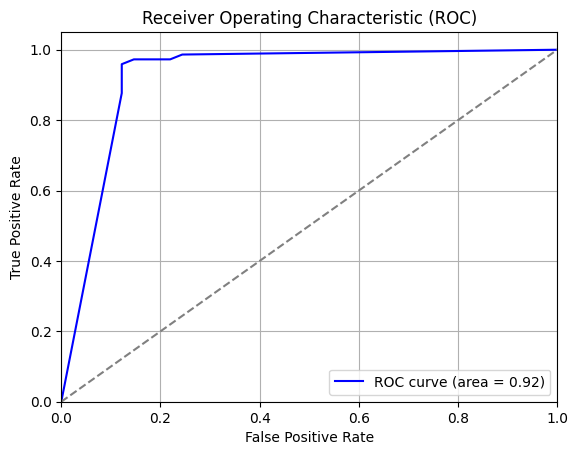

Confusion Matrix:
[[35  6]
 [ 2 71]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        41
           1       0.92      0.97      0.95        73

    accuracy                           0.93       114
   macro avg       0.93      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



In [39]:
# def predict(tree, instance):
#     while 'class' not in tree:
#         feature = tree['feature']
#         value = tree['value']
#         if instance[feature] < value:
#             tree = tree['left']
#         else:
#             tree = tree['right']
#         #print(tree)
#     return tree['class']
# def to_terminal(group):
#     outcomes = [row[-1] for row in group]
#     return max(set(outcomes), key=outcomes.count)

# def predict_all(tree, X_test):
#     predictions = []
#     for instance in X_test:
#         print(predict(tree, instance))
#         predictions.append(int(predict(tree, instance)))
#     return predictions

# from sklearn.metrics import accuracy_score

# y_pred = predict_all(tree, X_test)
# # print(y_pred)
# # print(y_test)
# print(accuracy_score(y_test, y_pred))
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Make a prediction with probabilities
def predict_proba(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict_proba(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict_proba(node['right'], row)
        else:
            return node['right']

# Get probability estimates for each test sample
y_probs = np.array([predict_proba(tree, row)[1] for row in X_test])  # Get probabilities for the positive class

# Convert probabilities to binary predictions
y_pred = np.array([1 if prob >= 0.5 else 0 for prob in y_probs])

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
# plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print confusion matrix and classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))



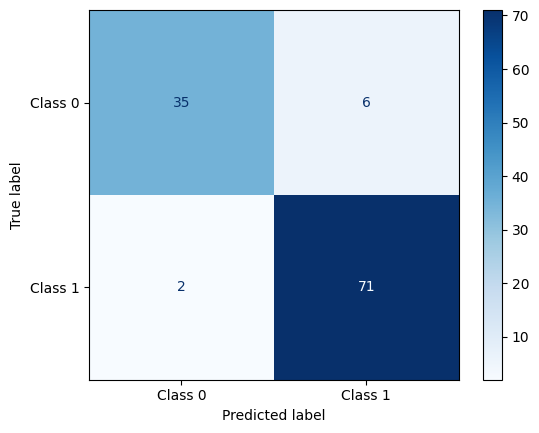

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have y_test and y_pred from your model
cm = confusion_matrix(y_test, y_pred)
# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()